# 模型打分與反事實一致性評測

本 Notebook 以兩個模型（Baseline 與 Fair）對資料集進行打分，輸出打分檔，並在反事實配對集上計算分數位移與決策翻轉率：
- 資料1：`pairs_longtext.csv`（主評測集）→ 產生 `baseline_scored.csv` 與 `fair_scored.csv`。
- 資料2：`counterfactual_pairs_longtext.csv`（反事實配對集）→ 產生 `counterfactual_scored.csv`，並計算位移與翻轉率（預設錄取率 r=10%）。

打分邏輯沿用 Inference Demo：
- 取最後隱層輸出做 mean pooling。
- L2 normalize 後用點積作為 cosine 相似度（raw_cosine）。
- 以 sigmoid(cosine) 當作機率分數（prob）。

In [1]:
# 1) Imports & basic setup
import os, json
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer

# Try optional peft import; fall back gracefully if missing
try:
    from peft import PeftModel  # type: ignore
except Exception:
    PeftModel = None
    print("peft not installed; remote LoRA adapter loading will be skipped. Install with `pip install peft`.")

DEVICE = torch.device('mps' if torch.backends.mps.is_available() else ('cuda' if torch.cuda.is_available() else 'cpu'))
BASE_MODEL = 'BAAI/bge-large-en-v1.5'
DATA_DIR = Path('..') / 'data' / 'eval'
OUT_BASELINE = DATA_DIR / 'baseline_scored.csv'
OUT_FAIR = DATA_DIR / 'fair_scored.csv'
OUT_CF = DATA_DIR / 'counterfactual_scored.csv'
print(f'Device: {DEVICE}')
print(f'Data dir: {DATA_DIR.resolve()}')

/opt/homebrew/Caskroom/miniconda/base/envs/ml-env/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Device: mps
Data dir: /Users/edwardhuang/Documents/GitHub/bge-lora-fairness-finetuning/data/eval


In [2]:
# 2) Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
tokenizer.model_max_length = 256
print('Tokenizer loaded.')

Tokenizer loaded.


## 載入兩個模型
- Baseline：Hugging Face 上的 LoRA adapter `shashu2325/resume-job-matcher-lora`（若無 peft 或下載失敗則退回 base）。
- Fair：本地 `models/fair_adversarial/best_fairness_model.pt` 權重（若不存在則使用 base 權重）。

In [3]:
# 3) Build Baseline model (base + remote LoRA if available)
REMOTE_ADAPTER_PATH = 'shashu2325/resume-job-matcher-lora'
base_model_for_baseline = AutoModel.from_pretrained(BASE_MODEL, torch_dtype=torch.float32)
if PeftModel is not None:
    try:
        baseline_model = PeftModel.from_pretrained(base_model_for_baseline, REMOTE_ADAPTER_PATH)
        print(f"Loaded remote LoRA adapter for baseline: {REMOTE_ADAPTER_PATH}")
    except Exception as e:
        print(f"Failed to load remote adapter: {e}; using base model as baseline.")
        baseline_model = base_model_for_baseline
else:
    print('peft not available; using base model as baseline.')
    baseline_model = base_model_for_baseline

baseline_model.to(DEVICE)
baseline_model.eval()
print('Baseline model ready.')

`torch_dtype` is deprecated! Use `dtype` instead!
/opt/homebrew/Caskroom/miniconda/base/envs/ml-env/lib/python3.11/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'
Loaded remote LoRA adapter for baseline: shashu2325/resume-job-matcher-lora
Baseline model ready.


In [4]:
# 4) Build Fair model (load local checkpoint if available)
LOCAL_FAIR_CKPT = Path('..') / 'models' / 'fair_adversarial' / 'best_fairness_model.pt'
fair_model = AutoModel.from_pretrained(BASE_MODEL, torch_dtype=torch.float32)
if LOCAL_FAIR_CKPT.exists():
    try:
        ckpt = torch.load(LOCAL_FAIR_CKPT, map_location=DEVICE)
        state = ckpt.get('model_state_dict', None) if isinstance(ckpt, dict) else None
        if state is None and isinstance(ckpt, dict):
            # sometimes saved as plain state_dict
            state = ckpt
        if state is not None:
            missing, unexpected = fair_model.load_state_dict(state, strict=False)
            print(f"Loaded local fair checkpoint: {LOCAL_FAIR_CKPT}")
            print('  Missing keys:', len(missing), '| Unexpected keys:', len(unexpected))
        else:
            print('Checkpoint found but no model_state_dict; skipped loading.')
    except Exception as e:
        print(f"Failed to load local fair checkpoint: {e}; using base model weights.")
else:
    print('Local fair checkpoint not found; using base model weights.')

fair_model.to(DEVICE)
fair_model.eval()
print('Fair model ready.')

Loaded local fair checkpoint: ../models/fair_adversarial/best_fairness_model.pt
  Missing keys: 391 | Unexpected keys: 715
Fair model ready.


## Encode 與打分輔助函數
提供批次處理，避免逐列呼叫過慢。

In [5]:
def encode_texts(texts, model, max_length=256, batch_size=32):
    """Return L2-normalized embeddings (on CPU) for a list of texts.
    texts: List[str]
    returns: torch.FloatTensor of shape [N, dim] on CPU
    """
    embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tokenizer(batch, return_tensors='pt', max_length=max_length, truncation=True, padding=True)
        enc = {k: v.to(DEVICE) for k, v in enc.items()}
        with torch.no_grad():
            out = model(**enc)
            hidden = out.last_hidden_state  # (b, t, d)
            emb = hidden.mean(dim=1)
            emb = F.normalize(emb, p=2, dim=1)
        embs.append(emb.cpu())
    return torch.cat(embs, dim=0) if embs else torch.empty(0)

def match_scores(texts_a, texts_b, model, batch_size=32):
    """Compute prob (sigmoid of cosine) and raw cosine for aligned pairs of texts.
    texts_a, texts_b: List[str] of same length
    returns: (probs: np.ndarray, cosines: np.ndarray)
    """
    assert len(texts_a) == len(texts_b), 'Pair lists must have same length'
    # Encode separately to keep memory low
    emb_a = encode_texts(texts_a, model, batch_size=batch_size)
    emb_b = encode_texts(texts_b, model, batch_size=batch_size)
    if len(emb_a) == 0:
        return np.array([]), np.array([])
    # Dot product row-wise (since normalized == cosine)
    cos = torch.sum(emb_a * emb_b, dim=1)
    prob = torch.sigmoid(cos)
    return prob.numpy(), cos.numpy()

print('Helpers ready.')

Helpers ready.


## 主評測集：`pairs_longtext.csv` 打分並輸出兩個檔
- baseline_scored.csv：原欄位 + baseline_prob, baseline_raw_cosine
- fair_scored.csv：原欄位 + fair_prob, fair_raw_cosine

In [6]:
pairs_path = DATA_DIR / 'pairs_longtext.csv'
assert pairs_path.exists(), f'File not found: {pairs_path}'
df_pairs = pd.read_csv(pairs_path)
# Basic sanitation
for col in ['resume_text', 'job_text']:
    if col in df_pairs:
        df_pairs[col] = df_pairs[col].fillna('')

# Baseline scoring
b_prob, b_cos = match_scores(df_pairs['resume_text'].tolist(), df_pairs['job_text'].tolist(), baseline_model, batch_size=32)
df_base = df_pairs.copy()
df_base['baseline_prob'] = b_prob
df_base['baseline_raw_cosine'] = b_cos
df_base.to_csv(OUT_BASELINE, index=False)
print(f'Wrote {OUT_BASELINE}')

# Fair scoring
f_prob, f_cos = match_scores(df_pairs['resume_text'].tolist(), df_pairs['job_text'].tolist(), fair_model, batch_size=32)
df_fair = df_pairs.copy()
df_fair['fair_prob'] = f_prob
df_fair['fair_raw_cosine'] = f_cos
df_fair.to_csv(OUT_FAIR, index=False)
print(f'Wrote {OUT_FAIR}')

Wrote ../data/eval/baseline_scored.csv
Wrote ../data/eval/fair_scored.csv


## 反事實配對集：`counterfactual_pairs_longtext.csv` 打分與一致性評測
輸出：`counterfactual_scored.csv` 加上四欄（base_prob_orig, base_prob_cf, fair_prob_orig, fair_prob_cf）。
同時計算：
- 位移（abs(prob_orig - prob_cf)）的平均與 P95。
- 決策翻轉率：固定錄取率 r（預設 10%），以原分佈設定門檻，觀察 orig 與 cf 是否翻轉。

In [8]:
cf_path = DATA_DIR / 'counterfactual_pairs_longtext.csv'
assert cf_path.exists(), f'File not found: {cf_path}'
df_cf = pd.read_csv(cf_path)
for col in ['resume_text_orig', 'resume_text_cf', 'job_text']:
    if col in df_cf:
        df_cf[col] = df_cf[col].fillna('')

# Baseline scores for orig/cf
b_prob_orig, _ = match_scores(df_cf['resume_text_orig'].tolist(), df_cf['job_text'].tolist(), baseline_model, batch_size=32)
b_prob_cf, _   = match_scores(df_cf['resume_text_cf'].tolist(),   df_cf['job_text'].tolist(), baseline_model, batch_size=32)
# Fair scores for orig/cf
f_prob_orig, _ = match_scores(df_cf['resume_text_orig'].tolist(), df_cf['job_text'].tolist(), fair_model, batch_size=32)
f_prob_cf, _   = match_scores(df_cf['resume_text_cf'].tolist(),   df_cf['job_text'].tolist(), fair_model, batch_size=32)

df_cf_scored = df_cf.copy()
df_cf_scored['base_prob_orig'] = b_prob_orig
df_cf_scored['base_prob_cf']   = b_prob_cf
df_cf_scored['fair_prob_orig'] = f_prob_orig
df_cf_scored['fair_prob_cf']   = f_prob_cf
df_cf_scored.to_csv(OUT_CF, index=False)
print(f'Wrote {OUT_CF}')

# Metrics: shift (mean/P95) and flip rate at acceptance rate r
def summarize_counterfactual(prob_orig, prob_cf, r=0.10, label='model'):
    prob_orig = np.asarray(prob_orig)
    prob_cf   = np.asarray(prob_cf)
    abs_shift = np.abs(prob_orig - prob_cf)
    mean_shift = float(abs_shift.mean()) if len(abs_shift) else 0.0
    p95_shift  = float(np.quantile(abs_shift, 0.95)) if len(abs_shift) else 0.0
    # Decision threshold from orig distribution (top-r accepted)
    thr = float(np.quantile(prob_orig, 1.0 - r)) if len(prob_orig) else 1.0
    dec_orig = (prob_orig >= thr)
    dec_cf   = (prob_cf   >= thr)
    flip_rate = float((dec_orig != dec_cf).mean()) if len(prob_orig) else 0.0
    print(f"[{label}] r={r*100:.0f}% | mean_shift={mean_shift:.4f} | p95_shift={p95_shift:.4f} | flip_rate={flip_rate:.4f} | thr={thr:.4f}")
    return {
        'r': r, 'mean_shift': mean_shift, 'p95_shift': p95_shift, 'flip_rate': flip_rate, 'threshold': thr
    }

summary_baseline = summarize_counterfactual(b_prob_orig, b_prob_cf, r=0.10, label='baseline')
summary_fair     = summarize_counterfactual(f_prob_orig, f_prob_cf, r=0.10, label='fair')

# Optional: store summaries as JSON next to CSV
with open(DATA_DIR / 'counterfactual_summary.json', 'w') as f:
    json.dump({'baseline': summary_baseline, 'fair': summary_fair}, f, indent=2)
print('Saved counterfactual_summary.json')

Wrote ../data/eval/counterfactual_scored.csv
[baseline] r=10% | mean_shift=0.0159 | p95_shift=0.0412 | flip_rate=0.1667 | thr=0.6809
[fair] r=10% | mean_shift=0.0057 | p95_shift=0.0136 | flip_rate=0.1552 | thr=0.6932
Saved counterfactual_summary.json


## 群體與個體公平分析（進一步）

以下使用本 Notebook 生成的分數直接計算：
- 群體公平（Demographic Parity, DP）在固定錄取率 r 下的 selection rate 差異。
- Top-K / 曝光：每個 job 的前 K 名群體比例與曝光份額。
- 個體公平（Local Consistency）：對同職位、相似履歷的分數差異。

In [9]:
# 7) 群體公平（DP）在固定錄取率 r 下的 selection rate 差異
import numpy as np
import pandas as pd

R_ACCEPT = 0.10  # 可調整

def selection_rate_parity(df: pd.DataFrame, prob_col: str, group_col: str, r: float = 0.10):
    df = df.copy()
    if prob_col not in df or group_col not in df:
        return None
    thr = float(np.quantile(df[prob_col].values, 1.0 - r))
    df['selected'] = df[prob_col] >= thr
    rates = df.groupby(group_col)['selected'].mean().to_dict()
    if len(rates) >= 2:
        dp_diff = float(max(rates.values()) - min(rates.values()))
    else:
        dp_diff = 0.0
    return {'threshold': thr, 'selection_rates': {str(k): float(v) for k, v in rates.items()}, 'dp_diff': dp_diff}

# Baseline: by is_top_school and school_category
if 'is_top_school' in df_base.columns:
    dp_base_top = selection_rate_parity(df_base, 'baseline_prob', 'is_top_school', r=R_ACCEPT)
    print('[Baseline][DP] is_top_school:', dp_base_top)
if 'school_category' in df_base.columns:
    dp_base_cat = selection_rate_parity(df_base, 'baseline_prob', 'school_category', r=R_ACCEPT)
    print('[Baseline][DP] school_category:', dp_base_cat)

# Fair: by is_top_school and school_category
if 'is_top_school' in df_fair.columns:
    dp_fair_top = selection_rate_parity(df_fair, 'fair_prob', 'is_top_school', r=R_ACCEPT)
    print('[Fair][DP] is_top_school:', dp_fair_top)
if 'school_category' in df_fair.columns:
    dp_fair_cat = selection_rate_parity(df_fair, 'fair_prob', 'school_category', r=R_ACCEPT)
    print('[Fair][DP] school_category:', dp_fair_cat)

[Baseline][DP] is_top_school: {'threshold': 0.6808725655078888, 'selection_rates': {'0': 0.10140405616224649, '1': 0.09717868338557993}, 'dp_diff': 0.0042253727766665555}
[Baseline][DP] school_category: {'threshold': 0.6808725655078888, 'selection_rates': {'A': 0.09717868338557993, 'B': 0.14473684210526316, 'C': 0.0804953560371517, 'D': 0.10240963855421686}, 'dp_diff': 0.06424148606811146}
[Fair][DP] is_top_school: {'threshold': 0.6932081282138824, 'selection_rates': {'0': 0.1029641185647426, '1': 0.09404388714733543}, 'dp_diff': 0.008920231417407165}
[Fair][DP] school_category: {'threshold': 0.6932081282138824, 'selection_rates': {'A': 0.09404388714733543, 'B': 0.13157894736842105, 'C': 0.10835913312693499, 'D': 0.06626506024096386}, 'dp_diff': 0.06531388712745718}


In [10]:
# 8) Top-K 與曝光：每個 job 的前 K 名群體比例與曝光份額
import numpy as np
import pandas as pd

TOP_K = 10  # 可調整

# position bias weights (higher weight for higher ranks)
expo_weights = np.array([1.0/np.log2(k+2) for k in range(TOP_K)], dtype=float)

def topk_exposure(df: pd.DataFrame, prob_col: str, group_col: str, job_col: str = 'job_id', K: int = 10):
    if not all(c in df.columns for c in [prob_col, group_col, job_col]):
        return None
    counts = {}
    exposure = {}
    total_in_topk = 0
    total_expo = 0.0
    for job, g in df.groupby(job_col):
        g_sorted = g.sort_values(prob_col, ascending=False).head(K)
        total_in_topk += len(g_sorted)
        for idx, (_, row) in enumerate(g_sorted.iterrows()):
            grp = row[group_col]
            counts[grp] = counts.get(grp, 0) + 1
            w = 1.0/np.log2(idx+2+1e-9)  # idx starts at 0; use log2(rank+2)
            exposure[grp] = exposure.get(grp, 0.0) + w
            total_expo += w
    frac = {str(k): (v/total_in_topk if total_in_topk>0 else 0.0) for k, v in counts.items()}
    expo_share = {str(k): (v/total_expo if total_expo>0 else 0.0) for k, v in exposure.items()}
    return {
        'K': K,
        'topk_fraction_by_group': frac,
        'exposure_share_by_group': expo_share,
        'total_topk': int(total_in_topk)
    }

# Baseline
if 'job_id' in df_base.columns and 'is_top_school' in df_base.columns:
    topk_base_top = topk_exposure(df_base, 'baseline_prob', 'is_top_school', job_col='job_id', K=TOP_K)
    print('[Baseline][TopK/Exposure] is_top_school:', topk_base_top)
if 'job_id' in df_base.columns and 'school_category' in df_base.columns:
    topk_base_cat = topk_exposure(df_base, 'baseline_prob', 'school_category', job_col='job_id', K=TOP_K)
    print('[Baseline][TopK/Exposure] school_category:', topk_base_cat)

# Fair
if 'job_id' in df_fair.columns and 'is_top_school' in df_fair.columns:
    topk_fair_top = topk_exposure(df_fair, 'fair_prob', 'is_top_school', job_col='job_id', K=TOP_K)
    print('[Fair][TopK/Exposure] is_top_school:', topk_fair_top)
if 'job_id' in df_fair.columns and 'school_category' in df_fair.columns:
    topk_fair_cat = topk_exposure(df_fair, 'fair_prob', 'school_category', job_col='job_id', K=TOP_K)
    print('[Fair][TopK/Exposure] school_category:', topk_fair_cat)

[Baseline][TopK/Exposure] is_top_school: {'K': 10, 'topk_fraction_by_group': {'0': 0.6416666666666667, '1': 0.35833333333333334}, 'exposure_share_by_group': {'0': 0.674132499464133, '1': 0.3258675005358673}, 'total_topk': 120}
[Baseline][TopK/Exposure] school_category: {'K': 10, 'topk_fraction_by_group': {'C': 0.2833333333333333, 'B': 0.175, 'D': 0.18333333333333332, 'A': 0.35833333333333334}, 'exposure_share_by_group': {'C': 0.2866040931345047, 'B': 0.16296036011327353, 'D': 0.2245680462163544, 'A': 0.3258675005358673}, 'total_topk': 120}
[Fair][TopK/Exposure] is_top_school: {'K': 10, 'topk_fraction_by_group': {'1': 0.3, '0': 0.7}, 'exposure_share_by_group': {'1': 0.27078886756016146, '0': 0.7292111324398387}, 'total_topk': 120}
[Fair][TopK/Exposure] school_category: {'K': 10, 'topk_fraction_by_group': {'A': 0.3, 'C': 0.36666666666666664, 'B': 0.18333333333333332, 'D': 0.15}, 'exposure_share_by_group': {'A': 0.27078886756016146, 'C': 0.375263364591311, 'B': 0.18873874636946175, 'D': 0

In [11]:
# 9) 個體公平（Local Consistency）：同職位相似履歷的分數差異
import numpy as np
from sklearn.neighbors import NearestNeighbors

# 以 baseline 模型的履歷 embedding 建鄰近圖，並在同一鄰近圖上分別量測 baseline 與 fair 的分數一致性
N_NEIGHBORS = 5       # 每個樣本的相似履歷數
SAMPLE_CAP_PER_JOB = 500  # 每個 job 取樣上限，避免過大資料計算過慢


def local_consistency_for_job(df_job, prob_cols, text_col='resume_text'):
    # 取樣以避免超大計算
    df_j = df_job.copy()
    if len(df_j) > SAMPLE_CAP_PER_JOB:
        df_j = df_j.sample(SAMPLE_CAP_PER_JOB, random_state=42).reset_index(drop=True)
    texts = df_j[text_col].fillna('').tolist()
    # 建 embeddings（baseline 模型即可）
    emb = encode_texts(texts, baseline_model, batch_size=64)
    if emb.shape[0] <= 1:
        return {pc: {'mean': 0.0, 'p95': 0.0} for pc in prob_cols}

    # 鄰近圖（cosine 距離）；NearestNeighbors 的 metric='cosine'，距離越小越近
    nn = NearestNeighbors(n_neighbors=min(N_NEIGHBORS+1, emb.shape[0]), metric='cosine')
    nn.fit(emb.numpy())
    distances, indices = nn.kneighbors(emb.numpy())

    # 去除自身（第一個通常是自己，距離=0）
    neighbor_indices = [idxs[1:] if len(idxs) > 1 else idxs for idxs in indices]

    out = {}
    for pc in prob_cols:
        scores = df_j[pc].values.astype(float)
        deltas = []
        for i, nbrs in enumerate(neighbor_indices):
            for j in nbrs:
                deltas.append(abs(scores[i] - scores[j]))
        if len(deltas) == 0:
            out[pc] = {'mean': 0.0, 'p95': 0.0}
        else:
            deltas = np.asarray(deltas)
            out[pc] = {
                'mean': float(deltas.mean()),
                'p95': float(np.quantile(deltas, 0.95))
            }
    return out


def local_consistency_overall(df_pairs_scored):
    if 'job_id' not in df_pairs_scored.columns:
        print('job_id not found; skip local consistency')
        return None
    results = []
    for job, g in df_pairs_scored.groupby('job_id'):
        res = local_consistency_for_job(g, prob_cols=['baseline_prob', 'fair_prob'])
        results.append({'job_id': job, **{f"{k}_{m}": v[m] for k, v in res.items() for m in ['mean', 'p95']}})
    if not results:
        return None
    df_res = pd.DataFrame(results)
    summary = {
        'baseline_mean_mean': float(df_res['baseline_prob_mean'].mean()),
        'baseline_mean_p95': float(df_res['baseline_prob_p95'].mean()),
        'fair_mean_mean': float(df_res['fair_prob_mean'].mean()),
        'fair_mean_p95': float(df_res['fair_prob_p95'].mean()),
    }
    return {'per_job': df_res, 'summary': summary}

# 構建合併後的資料（對齊相同行順序）
df_pairs_scored = df_base[['job_id','resume_text','baseline_prob']].copy()
if 'fair_prob' in df_fair.columns:
    df_pairs_scored['fair_prob'] = df_fair['fair_prob'].values

lc = local_consistency_overall(df_pairs_scored)
if lc is not None:
    print('[Local Consistency][Summary]:', lc['summary'])

[Local Consistency][Summary]: {'baseline_mean_mean': 0.009084734084705512, 'baseline_mean_p95': 0.022078687449296308, 'fair_mean_mean': 0.004569848328828812, 'fair_mean_p95': 0.011678169667720785}


## Visualizations (English)

This section renders visual summaries:
- Overall score distributions (baseline vs fair)
- Demographic Parity (selection rates by group) side-by-side
- Top-K fraction and Exposure share by group per job
- Counterfactual shifts (orig vs counterfactual) and flip rate
- Local consistency summary (average neighbor delta)

In [12]:
# 10) Visualization Dashboard
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

SAVE_FIGS = True
FIG_DIR = Path('..') / 'reports' / 'figures' / 'fairness_eval'
if SAVE_FIGS:
    FIG_DIR.mkdir(parents=True, exist_ok=True)

# Fallbacks for parameters
R_ACCEPT = globals().get('R_ACCEPT', 0.10)
TOP_K = globals().get('TOP_K', 10)

# Helper: selection-rate parity
if 'selection_rate_parity' not in globals():
    def selection_rate_parity(df: pd.DataFrame, prob_col: str, group_col: str, r: float = 0.10):
        d = df[[prob_col, group_col]].dropna().copy()
        if d.empty:
            return None
        thr = float(np.quantile(d[prob_col].values, 1.0 - r))
        d['selected'] = d[prob_col] >= thr
        rates = d.groupby(group_col)['selected'].mean().to_dict()
        dp_diff = float(max(rates.values()) - min(rates.values())) if len(rates) >= 2 else 0.0
        return {'threshold': thr, 'selection_rates': {str(k): float(v) for k, v in rates.items()}, 'dp_diff': dp_diff}

# Helper: top-K exposure
if 'topk_exposure' not in globals():
    def topk_exposure(df: pd.DataFrame, prob_col: str, group_col: str, job_col: str = 'job_id', K: int = 10):
        if not all(c in df.columns for c in [prob_col, group_col, job_col]):
            return None
        counts, exposure = {}, {}
        total_in_topk, total_expo = 0, 0.0
        for job, g in df.groupby(job_col):
            g_sorted = g.sort_values(prob_col, ascending=False).head(K)
            total_in_topk += len(g_sorted)
            for idx, (_, row) in enumerate(g_sorted.iterrows()):
                grp = row[group_col]
                counts[grp] = counts.get(grp, 0) + 1
                w = 1.0/np.log2(idx+2+1e-9)
                exposure[grp] = exposure.get(grp, 0.0) + w
                total_expo += w
        frac = {str(k): (v/total_in_topk if total_in_topk>0 else 0.0) for k, v in counts.items()}
        expo_share = {str(k): (v/total_expo if total_expo>0 else 0.0) for k, v in exposure.items()}
        return {'K': K, 'topk_fraction_by_group': frac, 'exposure_share_by_group': expo_share, 'total_topk': int(total_in_topk)}

# 10.1 Score distribution
try:
    fig, ax = plt.subplots(figsize=(8,5))
    if 'baseline_prob' in df_base.columns:
        sns.kdeplot(df_base['baseline_prob'], ax=ax, label='Baseline prob', fill=True, alpha=0.3)
    if 'fair_prob' in df_fair.columns:
        sns.kdeplot(df_fair['fair_prob'], ax=ax, label='Fair prob', fill=True, alpha=0.3)
    ax.set_title('Score Distribution (Probability)')
    ax.set_xlabel('Probability')
    ax.set_ylabel('Density')
    ax.legend()
    plt.tight_layout()
    if SAVE_FIGS:
        plt.savefig(FIG_DIR / 'score_distribution.png', dpi=200)
    plt.show()
except Exception as e:
    print('Score distribution plot skipped:', e)

# 10.2 Demographic Parity by is_top_school (if available)
for group_col in ['is_top_school', 'school_category']:
    try:
        rows = []
        if group_col in df_base.columns:
            dp_b = selection_rate_parity(df_base, 'baseline_prob', group_col, r=R_ACCEPT)
            if dp_b:
                for g, v in dp_b['selection_rates'].items():
                    rows.append({'group': g, 'model': 'Baseline', 'selection_rate': v})
        if group_col in df_fair.columns:
            dp_f = selection_rate_parity(df_fair, 'fair_prob', group_col, r=R_ACCEPT)
            if dp_f:
                for g, v in dp_f['selection_rates'].items():
                    rows.append({'group': g, 'model': 'Fair', 'selection_rate': v})
        if rows:
            df_plot = pd.DataFrame(rows)
            fig, ax = plt.subplots(figsize=(8,5))
            sns.barplot(data=df_plot, x='group', y='selection_rate', hue='model', ax=ax)
            ax.set_title(f'Demographic Parity by {group_col} (r={int(R_ACCEPT*100)}%)')
            ax.set_xlabel(group_col)
            ax.set_ylabel('Selection Rate')
            plt.tight_layout()
            if SAVE_FIGS:
                plt.savefig(FIG_DIR / f'dp_{group_col}.png', dpi=200)
            plt.show()
    except Exception as e:
        print(f'DP plot for {group_col} skipped:', e)

# 10.3 Top-K fraction and exposure by is_top_school (if job_id available)
for group_col in ['is_top_school', 'school_category']:
    try:
        rows_frac, rows_expo = [], []
        if all(c in df_base.columns for c in ['job_id', group_col, 'baseline_prob']):
            t_b = topk_exposure(df_base, 'baseline_prob', group_col, job_col='job_id', K=TOP_K)
            if t_b:
                for g, v in t_b['topk_fraction_by_group'].items():
                    rows_frac.append({'group': g, 'model': 'Baseline', 'fraction': v})
                for g, v in t_b['exposure_share_by_group'].items():
                    rows_expo.append({'group': g, 'model': 'Baseline', 'exposure': v})
        if all(c in df_fair.columns for c in ['job_id', group_col, 'fair_prob']):
            t_f = topk_exposure(df_fair, 'fair_prob', group_col, job_col='job_id', K=TOP_K)
            if t_f:
                for g, v in t_f['topk_fraction_by_group'].items():
                    rows_frac.append({'group': g, 'model': 'Fair', 'fraction': v})
                for g, v in t_f['exposure_share_by_group'].items():
                    rows_expo.append({'group': g, 'model': 'Fair', 'exposure': v})
        if rows_frac:
            df_frac = pd.DataFrame(rows_frac)
            fig, ax = plt.subplots(figsize=(8,5))
            sns.barplot(data=df_frac, x='group', y='fraction', hue='model', ax=ax)
            ax.set_title(f'Top-{TOP_K} Fraction by {group_col}')
            ax.set_xlabel(group_col)
            ax.set_ylabel('Fraction in Top-K')
            plt.tight_layout()
            if SAVE_FIGS:
                plt.savefig(FIG_DIR / f'topk_fraction_{group_col}.png', dpi=200)
            plt.show()
        if rows_expo:
            df_expo = pd.DataFrame(rows_expo)
            fig, ax = plt.subplots(figsize=(8,5))
            sns.barplot(data=df_expo, x='group', y='exposure', hue='model', ax=ax)
            ax.set_title(f'Exposure Share by {group_col} (Top-{TOP_K})')
            ax.set_xlabel(group_col)
            ax.set_ylabel('Exposure Share')
            plt.tight_layout()
            if SAVE_FIGS:
                plt.savefig(FIG_DIR / f'exposure_share_{group_col}.png', dpi=200)
            plt.show()
    except Exception as e:
        print(f'Top-K/Exposure plot for {group_col} skipped:', e)

# 10.4 Counterfactual shift & flip rate
try:
    # Build from previously computed arrays if available; otherwise recompute from df_cf_scored
    if 'b_prob_orig' in globals() and 'b_prob_cf' in globals():
        b_po, b_pc = np.asarray(b_prob_orig), np.asarray(b_prob_cf)
    else:
        if 'df_cf_scored' in globals():
            b_po = df_cf_scored['base_prob_orig'].values
            b_pc = df_cf_scored['base_prob_cf'].values
        else:
            b_po = b_pc = np.array([])
    if 'f_prob_orig' in globals() and 'f_prob_cf' in globals():
        f_po, f_pc = np.asarray(f_prob_orig), np.asarray(f_prob_cf)
    else:
        if 'df_cf_scored' in globals():
            f_po = df_cf_scored['fair_prob_orig'].values
            f_pc = df_cf_scored['fair_prob_cf'].values
        else:
            f_po = f_pc = np.array([])
    # Shift distributions
    if len(b_po) > 0 and len(b_pc) > 0:
        b_shift = np.abs(b_po - b_pc)
    else:
        b_shift = np.array([])
    if len(f_po) > 0 and len(f_pc) > 0:
        f_shift = np.abs(f_po - f_pc)
    else:
        f_shift = np.array([])
    # Plot shift KDE
    if b_shift.size or f_shift.size:
        fig, ax = plt.subplots(figsize=(8,5))
        if b_shift.size:
            sns.kdeplot(b_shift, ax=ax, label='Baseline shift', fill=True, alpha=0.3)
        if f_shift.size:
            sns.kdeplot(f_shift, ax=ax, label='Fair shift', fill=True, alpha=0.3)
        ax.set_title('Counterfactual Score Shift (|orig - cf|)')
        ax.set_xlabel('Absolute Shift')
        ax.set_ylabel('Density')
        ax.legend()
        plt.tight_layout()
        if SAVE_FIGS:
            plt.savefig(FIG_DIR / 'counterfactual_shift.png', dpi=200)
        plt.show()
    # Flip rate bar
    def flip_rate(arr_o, arr_c, r=0.10):
        if len(arr_o) == 0:
            return 0.0
        thr = float(np.quantile(arr_o, 1.0 - r))
        return float(((arr_o >= thr) != (arr_c >= thr)).mean())
    if len(b_po) and len(b_pc) and len(f_po) and len(f_pc):
        fr_b = flip_rate(b_po, b_pc, r=R_ACCEPT)
        fr_f = flip_rate(f_po, f_pc, r=R_ACCEPT)
        fig, ax = plt.subplots(figsize=(6,4))
        ax.bar(['Baseline', 'Fair'], [fr_b, fr_f], color=['#999','#2a9d8f'])
        ax.set_title(f'Flip Rate at r={int(R_ACCEPT*100)}%')
        ax.set_ylabel('Flip Rate')
        for i, v in enumerate([fr_b, fr_f]):
            ax.text(i, v + 0.005, f'{v:.3f}', ha='center')
        plt.ylim(0, max(fr_b, fr_f)*1.2 + 0.05)
        plt.tight_layout()
        if SAVE_FIGS:
            plt.savefig(FIG_DIR / 'flip_rate.png', dpi=200)
        plt.show()
except Exception as e:
    print('Counterfactual plots skipped:', e)

# 10.5 Local consistency summary bar (if computed)
try:
    if 'lc' in globals() and lc and 'summary' in lc:
        s = lc['summary']
        fig, ax = plt.subplots(figsize=(6,4))
        ax.bar(['Baseline', 'Fair'], [s['baseline_mean_mean'], s['fair_mean_mean']], color=['#999','#2a9d8f'])
        ax.set_title('Local Consistency (Mean Neighbor Delta)')
        ax.set_ylabel('Mean |Δ score|')
        for i, v in enumerate([s['baseline_mean_mean'], s['fair_mean_mean']]):
            ax.text(i, v + 0.001, f'{v:.3f}', ha='center')
        plt.tight_layout()
        if SAVE_FIGS:
            plt.savefig(FIG_DIR / 'local_consistency_mean.png', dpi=200)
        plt.show()
except Exception as e:
    print('Local consistency plot skipped:', e)

print('Visualization completed. Figures saved to:', FIG_DIR if SAVE_FIGS else 'not saved')

NotADirectoryError: [Errno 20] Not a directory: '../reports/figures/fairness_eval'

## Additional Visual Insights (English)

Extra plots to further compare models:
- Baseline vs Fair probability scatter with y=x reference
- Group-wise probability distributions (violin/box)
- Position-wise exposure curve across ranks (aggregated over jobs)
- Counterfactual orig vs cf scatter with y=x reference
- Distribution of Fair − Baseline probability differences

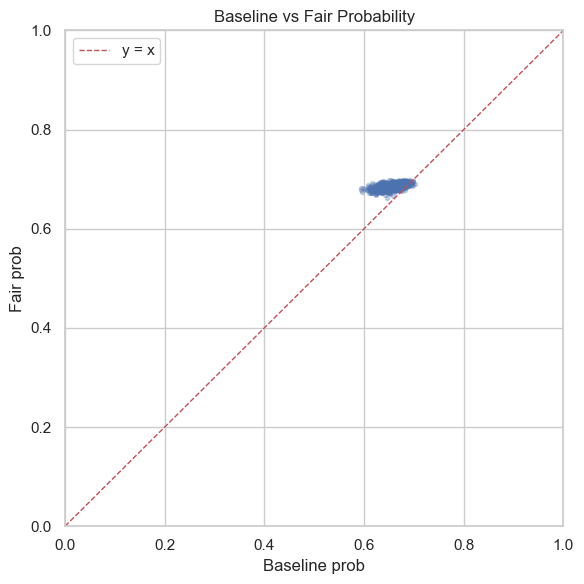

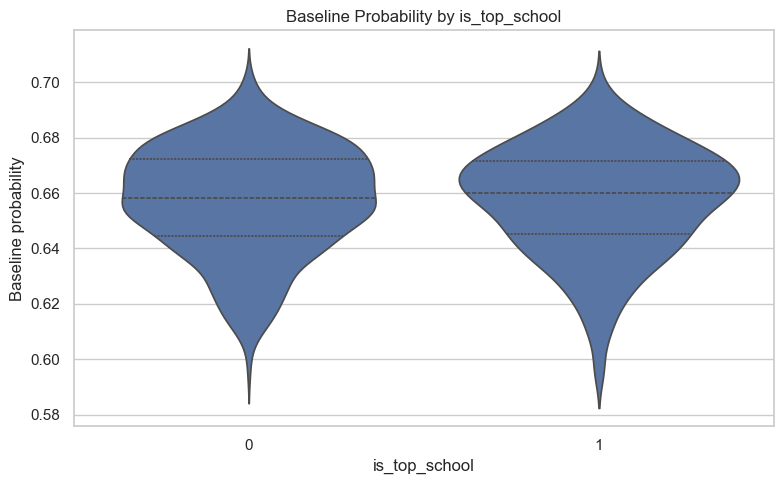

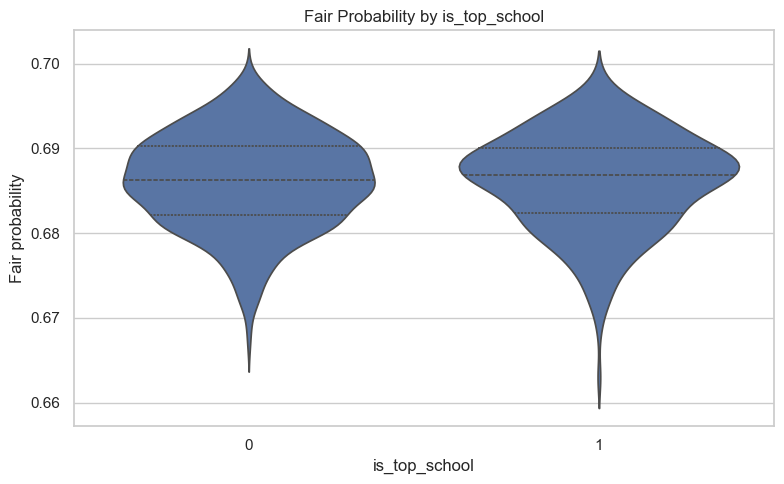

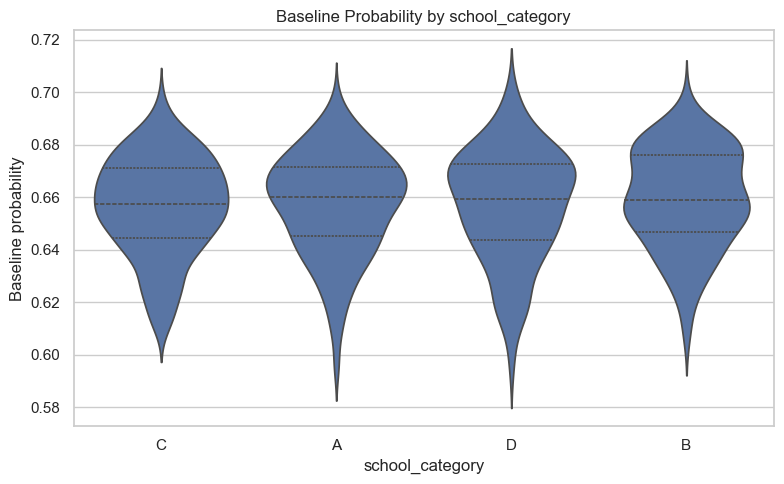

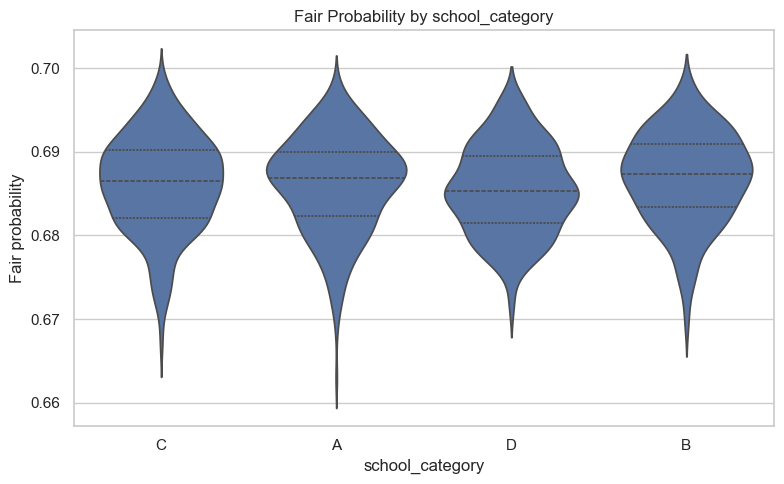

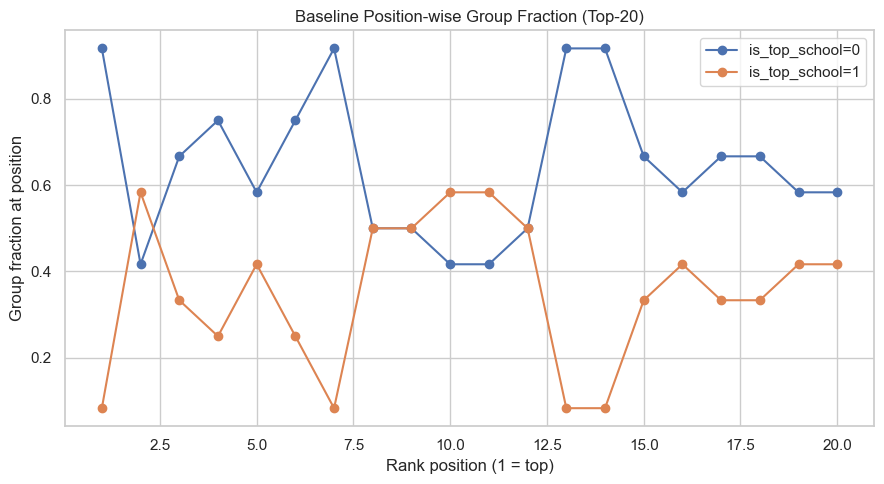

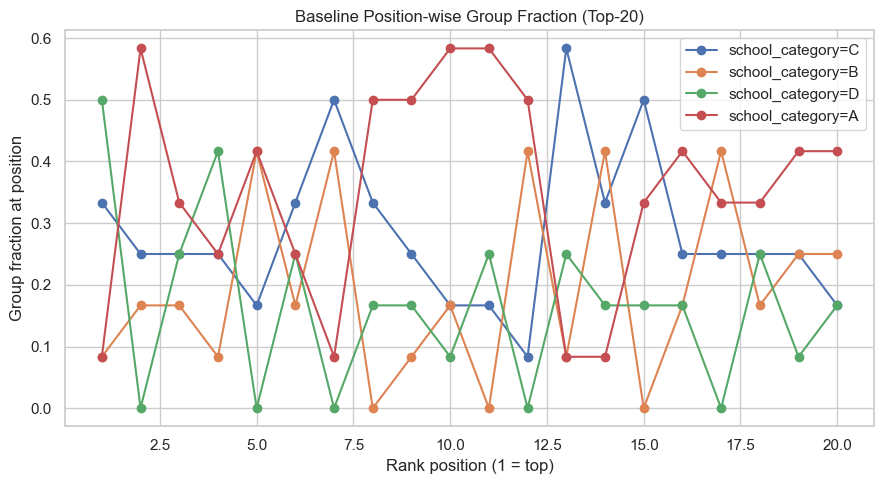

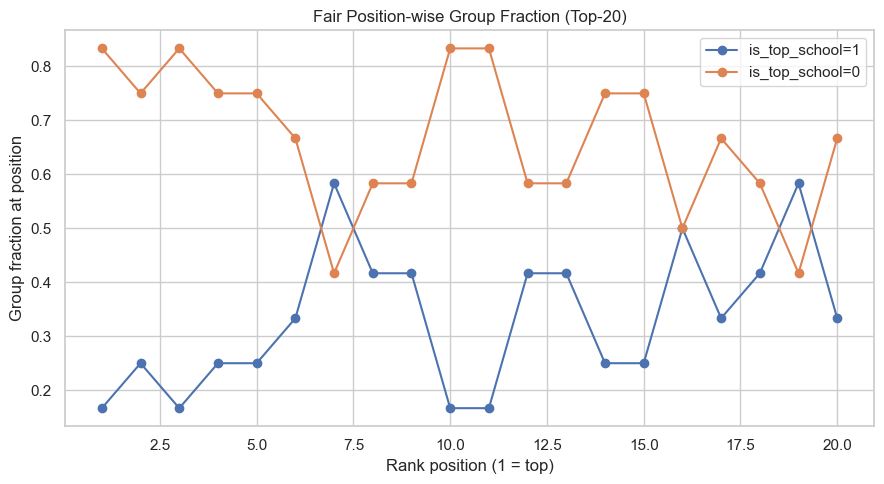

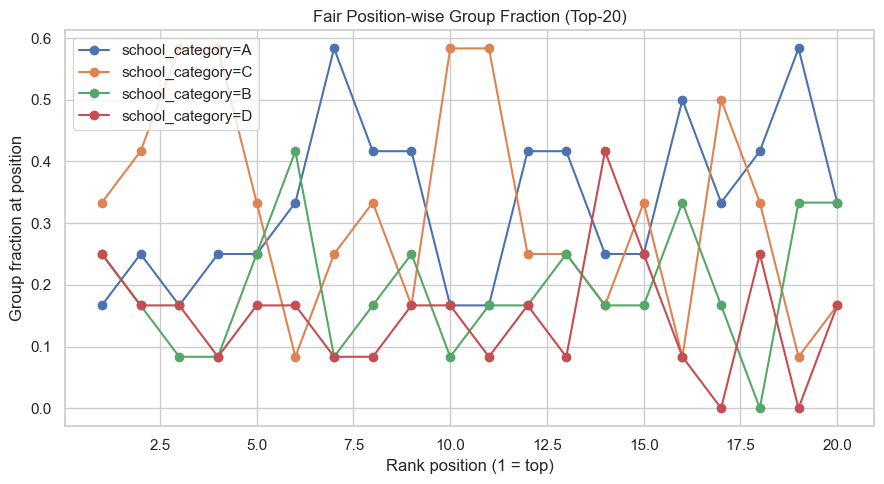

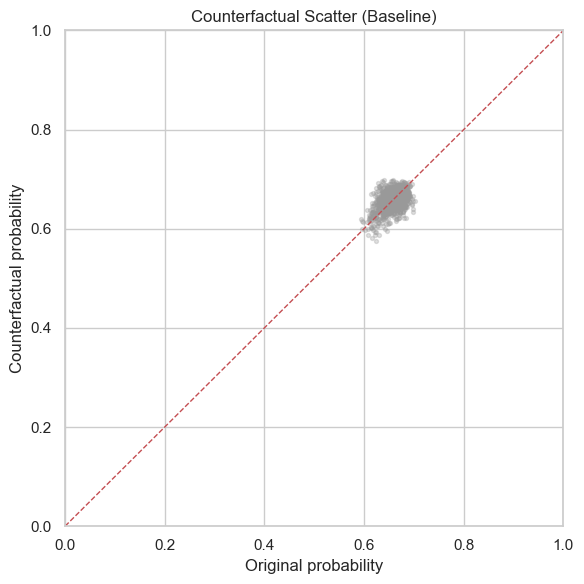

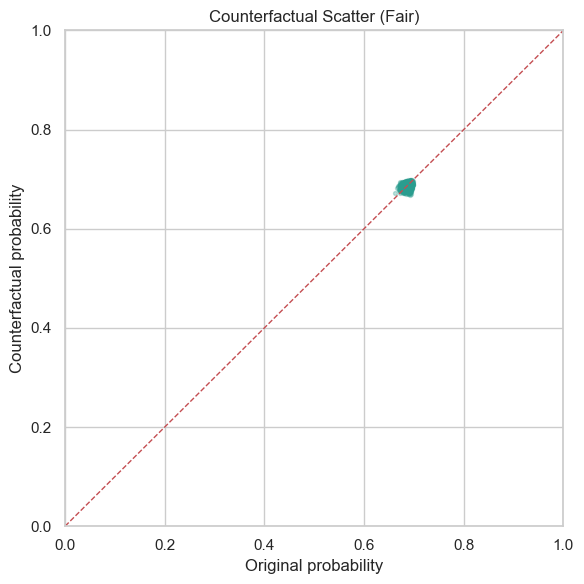

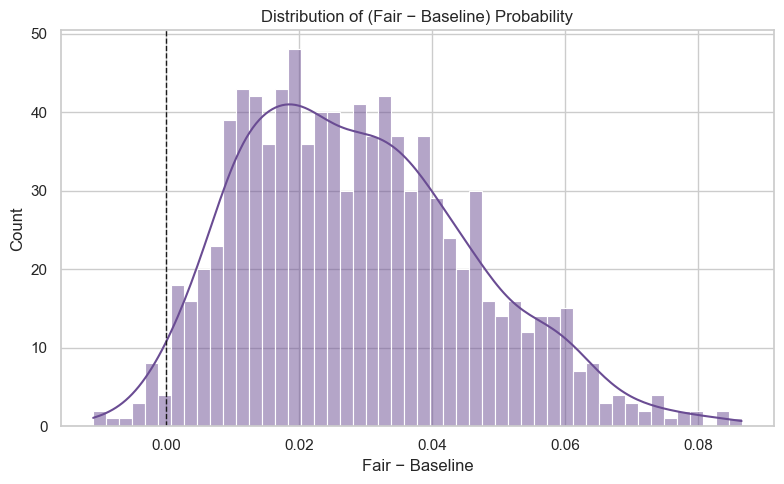

Additional visuals completed. Figures saved to: ../reports/fairness_metrics


In [15]:
# 11) Additional Visual Insights Code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set(style='whitegrid')
SAVE_FIGS = globals().get('SAVE_FIGS', True)
FIG_DIR = Path('..') / 'reports' /  'fairness_metrics'
if SAVE_FIGS:
    FIG_DIR.mkdir(parents=True, exist_ok=True)

# 11.1 Baseline vs Fair probability scatter
try:
    if 'fair_prob' in df_fair.columns and 'baseline_prob' in df_base.columns:
        # Align rows by original order assumption
        x = df_base['baseline_prob'].values
        y = df_fair['fair_prob'].values
        n = min(len(x), len(y))
        x, y = x[:n], y[:n]
        fig, ax = plt.subplots(figsize=(6,6))
        ax.scatter(x, y, s=8, alpha=0.3)
        lims = [0, 1]
        ax.plot(lims, lims, 'r--', linewidth=1, label='y = x')
        ax.set_xlim(lims)
        ax.set_ylim(lims)
        ax.set_title('Baseline vs Fair Probability')
        ax.set_xlabel('Baseline prob')
        ax.set_ylabel('Fair prob')
        ax.legend()
        plt.tight_layout()
        if SAVE_FIGS:
            plt.savefig(FIG_DIR / 'baseline_vs_fair_scatter.png', dpi=200)
        plt.show()
except Exception as e:
    print('Baseline vs Fair scatter skipped:', e)

# 11.2 Group-wise probability distributions
for group_col in ['is_top_school', 'school_category']:
    try:
        if group_col in df_base.columns and 'baseline_prob' in df_base.columns:
            fig, ax = plt.subplots(figsize=(8,5))
            sns.violinplot(data=df_base, x=group_col, y='baseline_prob', ax=ax, inner='quartile')
            ax.set_title(f'Baseline Probability by {group_col}')
            ax.set_xlabel(group_col)
            ax.set_ylabel('Baseline probability')
            plt.tight_layout()
            if SAVE_FIGS:
                plt.savefig(FIG_DIR / f'violin_baseline_prob_{group_col}.png', dpi=200)
            plt.show()
        if group_col in df_fair.columns and 'fair_prob' in df_fair.columns:
            fig, ax = plt.subplots(figsize=(8,5))
            sns.violinplot(data=df_fair, x=group_col, y='fair_prob', ax=ax, inner='quartile')
            ax.set_title(f'Fair Probability by {group_col}')
            ax.set_xlabel(group_col)
            ax.set_ylabel('Fair probability')
            plt.tight_layout()
            if SAVE_FIGS:
                plt.savefig(FIG_DIR / f'violin_fair_prob_{group_col}.png', dpi=200)
            plt.show()
    except Exception as e:
        print(f'Group distribution plots for {group_col} skipped:', e)

# 11.3 Position-wise exposure curve across ranks (aggregated)
try:
    def exposure_curve(df: pd.DataFrame, prob_col: str, job_col='job_id', group_col='is_top_school', max_k=20):
        if not all(c in df.columns for c in [prob_col, job_col, group_col]):
            return None
        # Aggregate average group share at each rank position over all jobs
        pos_counts = {}
        pos_totals = np.zeros(max_k, dtype=float)
        for _, g in df.groupby(job_col):
            g_sorted = g.sort_values(prob_col, ascending=False).head(max_k)
            for idx, (_, row) in enumerate(g_sorted.iterrows()):
                grp = row[group_col]
                pos_counts.setdefault(grp, np.zeros(max_k, dtype=float))[idx] += 1.0
                pos_totals[idx] += 1.0
        if pos_totals.sum() == 0:
            return None
        # Normalize to fraction per rank position
        curves = {str(k): (v / np.maximum(pos_totals, 1e-9)).tolist() for k, v in pos_counts.items()}
        return curves

    for model_name, df_m, prob_col in [
        ('Baseline', df_base, 'baseline_prob'),
        ('Fair', df_fair, 'fair_prob')
    ]:
        for group_col in ['is_top_school', 'school_category']:
            curves = exposure_curve(df_m, prob_col, job_col='job_id', group_col=group_col, max_k=20)
            if curves:
                fig, ax = plt.subplots(figsize=(9,5))
                for grp, ys in curves.items():
                    ax.plot(range(1, len(ys)+1), ys, marker='o', label=f'{group_col}={grp}')
                ax.set_title(f'{model_name} Position-wise Group Fraction (Top-20)')
                ax.set_xlabel('Rank position (1 = top)')
                ax.set_ylabel('Group fraction at position')
                ax.legend()
                plt.tight_layout()
                if SAVE_FIGS:
                    fname = f'exposure_curve_{model_name.lower()}_{group_col}.png'
                    plt.savefig(FIG_DIR / fname, dpi=200)
                plt.show()
except Exception as e:
    print('Exposure curve plots skipped:', e)

# 11.4 Counterfactual scatter: orig vs cf
try:
    if 'df_cf_scored' in globals():
        # Baseline
        if all(c in df_cf_scored.columns for c in ['base_prob_orig', 'base_prob_cf']):
            x, y = df_cf_scored['base_prob_orig'].values, df_cf_scored['base_prob_cf'].values
            fig, ax = plt.subplots(figsize=(6,6))
            ax.scatter(x, y, s=8, alpha=0.3, color='#999')
            ax.plot([0,1], [0,1], 'r--', linewidth=1)
            ax.set_title('Counterfactual Scatter (Baseline)')
            ax.set_xlabel('Original probability')
            ax.set_ylabel('Counterfactual probability')
            ax.set_xlim(0,1); ax.set_ylim(0,1)
            plt.tight_layout()
            if SAVE_FIGS:
                plt.savefig(FIG_DIR / 'cf_scatter_baseline.png', dpi=200)
            plt.show()
        # Fair
        if all(c in df_cf_scored.columns for c in ['fair_prob_orig', 'fair_prob_cf']):
            x, y = df_cf_scored['fair_prob_orig'].values, df_cf_scored['fair_prob_cf'].values
            fig, ax = plt.subplots(figsize=(6,6))
            ax.scatter(x, y, s=8, alpha=0.3, color='#2a9d8f')
            ax.plot([0,1], [0,1], 'r--', linewidth=1)
            ax.set_title('Counterfactual Scatter (Fair)')
            ax.set_xlabel('Original probability')
            ax.set_ylabel('Counterfactual probability')
            ax.set_xlim(0,1); ax.set_ylim(0,1)
            plt.tight_layout()
            if SAVE_FIGS:
                plt.savefig(FIG_DIR / 'cf_scatter_fair.png', dpi=200)
            plt.show()
except Exception as e:
    print('Counterfactual scatter plots skipped:', e)

# 11.5 Distribution of Fair − Baseline probability differences
try:
    if 'fair_prob' in df_fair.columns and 'baseline_prob' in df_base.columns:
        n = min(len(df_fair), len(df_base))
        diff = df_fair['fair_prob'].values[:n] - df_base['baseline_prob'].values[:n]
        fig, ax = plt.subplots(figsize=(8,5))
        sns.histplot(diff, bins=50, kde=True, ax=ax, color='#6a4c93')
        ax.axvline(0, color='k', linestyle='--', linewidth=1)
        ax.set_title('Distribution of (Fair − Baseline) Probability')
        ax.set_xlabel('Fair − Baseline')
        ax.set_ylabel('Count')
        plt.tight_layout()
        if SAVE_FIGS:
            plt.savefig(FIG_DIR / 'diff_fair_minus_baseline.png', dpi=200)
        plt.show()
except Exception as e:
    print('Difference distribution plot skipped:', e)

print('Additional visuals completed. Figures saved to:', FIG_DIR if SAVE_FIGS else 'not saved')